# Kaggle - Space Titanic - Spark framework

This notebooks is used as practice for ML applied to Kaggle Space Titanic training problem and pySpark practice
https://www.kaggle.com/competitions/spaceship-titanic/data?select=train.csv

In [340]:
# import libraries
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
from pyspark.ml import Pipeline
from pyspark.ml.functions import vector_to_array
from pyspark.ml.stat import Correlation, ChiSquareTest
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, VectorIndexer, MinMaxScaler, VectorSlicer
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from xgboost.spark import SparkXGBClassifier

import pandas as pd
import numpy as np
import seaborn as sns

## Import data to local Spark Framework

Load data from CSV and organize schema

In [341]:
# set env viroment for localhost
spark = SparkSession.builder.config("spark.driver.host", "localhost").getOrCreate()
# spark = SparkSession.builder.master("local[*]").getOrCreate()

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled","true")

# show spark session details
spark

In [342]:
# define data schema
customSchema = StructType([
    StructField('PassengerId', StringType(), True),
    StructField('HomePlanet', StringType(), True),    
    StructField('CryoSleep', StringType(), True),
    StructField('Cabin', StringType(), True),
    StructField('Destination', StringType(), True),
    StructField('Age', DoubleType(), True),
    StructField('VIP', StringType(), True),
    StructField('RoomService', DoubleType(), True),
    StructField('FoodCourt', DoubleType(), True),
    StructField('ShoppingMall', DoubleType(), True),
    StructField('Spa', DoubleType(), True),
    StructField('VRDeck', DoubleType(), True),
    StructField('Name', StringType(), True),
    StructField('Transported', StringType(), True),
])

# load data
train_spark = spark.read.format('csv').option('header',True).schema(customSchema).load('./train.csv')
test_spark = spark.read.format('csv').option('header',True).schema(customSchema).load('./test.csv')

In [343]:
# split cabin string
def split_cabin(spark_df):
    spark_df = spark_df.withColumn('deck', split(spark_df['Cabin'], '/').getItem(0)) \
              .withColumn('num', split(spark_df['Cabin'], '/').getItem(1).cast('double')) \
              .withColumn('side', split(spark_df['Cabin'], '/').getItem(2))
    spark_df = spark_df.fillna(subset=['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','num'],
        value=0)
    return spark_df
    
train_spark = split_cabin(train_spark)
test_spark = split_cabin(test_spark)

In [344]:
# show data schema and sample
train_spark.show()
train_spark.printSchema()

+-----------+----------+---------+-----+-------------+----+-----+-----------+---------+------------+------+------+------------------+-----------+----+---+----+
|PassengerId|HomePlanet|CryoSleep|Cabin|  Destination| Age|  VIP|RoomService|FoodCourt|ShoppingMall|   Spa|VRDeck|              Name|Transported|deck|num|side|
+-----------+----------+---------+-----+-------------+----+-----+-----------+---------+------------+------+------+------------------+-----------+----+---+----+
|    0001_01|    Europa|    False|B/0/P|  TRAPPIST-1e|39.0|False|        0.0|      0.0|         0.0|   0.0|   0.0|   Maham Ofracculy|      False|   B|0.0|   P|
|    0002_01|     Earth|    False|F/0/S|  TRAPPIST-1e|24.0|False|      109.0|      9.0|        25.0| 549.0|  44.0|      Juanna Vines|       True|   F|0.0|   S|
|    0003_01|    Europa|    False|A/0/S|  TRAPPIST-1e|58.0| True|       43.0|   3576.0|         0.0|6715.0|  49.0|     Altark Susent|      False|   A|0.0|   S|
|    0003_02|    Europa|    False|A/0/S|

## Data wrangling

In [345]:
# data formating pipeline
cate_list = ['HomePlanet','Destination','deck','side']
bool_list = ['Transported','CryoSleep','VIP']
float_list = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','num']

stages_list = []
# convert strings to indexes
stages_list = stages_list + [
        StringIndexer(inputCol=c, outputCol=c+'_idx', handleInvalid='keep')
        for c in cate_list + bool_list
]

# vectorize columns
stages_list = stages_list + [
        VectorAssembler(inputCols=[c+'_idx'], outputCol=c+'_vec', handleInvalid='keep')
        for c in cate_list + bool_list
]

stages_list = stages_list + [
        VectorAssembler(inputCols=[c], outputCol=c+'_vec', handleInvalid='keep')
        for c in float_list
]

# minmax scale floats
stages_list = stages_list + [
        MinMaxScaler(inputCol=c+"_vec", outputCol=c+"_scaled") for c in float_list
]

# one hot encode
stages_list = stages_list + [OneHotEncoder(inputCols=[c+"_idx" for c in cate_list],
        outputCols=[c+"_ohe" for c in cate_list], handleInvalid='keep'
)]

pipeline = Pipeline(stages=stages_list)

pipeline = pipeline.fit(train_spark)

train_df = pipeline.transform(train_spark)
test_df = pipeline.transform(test_spark)

train_df = train_df.dropna(subset=['Transported'])

train_df.show()

+-----------+----------+---------+-----+-------------+----+-----+-----------+---------+------------+------+------+------------------+-----------+----+---+----+--------------+---------------+--------+--------+---------------+-------------+-------+--------------+---------------+--------+--------+---------------+-------------+-------+-------+---------------+-------------+----------------+--------+----------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+---------------+-------------+-------------+
|PassengerId|HomePlanet|CryoSleep|Cabin|  Destination| Age|  VIP|RoomService|FoodCourt|ShoppingMall|   Spa|VRDeck|              Name|Transported|deck|num|side|HomePlanet_idx|Destination_idx|deck_idx|side_idx|Transported_idx|CryoSleep_idx|VIP_idx|HomePlanet_vec|Destination_vec|deck_vec|side_vec|Transported_vec|CryoSleep_vec|VIP_vec|Age_vec|RoomService_vec|FoodCourt_vec|Shoppi

### Feature analysis (correlation and p-value)

In [346]:
# adjust aux dataframes for feature analysis

bool_list = ['Transported_idx','CryoSleep','VIP']
scaled_list = ['Age_scaled','RoomService_scaled','FoodCourt_scaled','ShoppingMall_scaled','Spa_scaled','VRDeck_scaled','num_scaled']
# scaled_list = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','num']

cont_spark_df = train_df.select(scaled_list + ['Transported_idx'])
for c in scaled_list:
    cont_spark_df = cont_spark_df.withColumn(c+'_', vector_to_array(col(c))[0])
cont_spark_df = cont_spark_df.drop(*scaled_list)
    

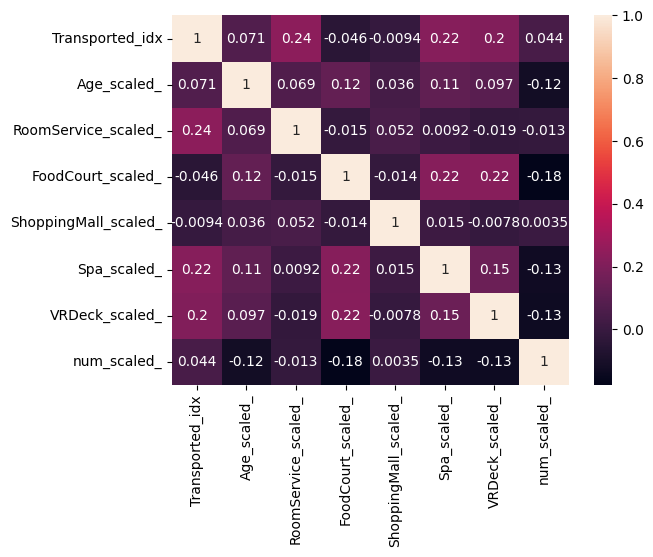

In [347]:

cor_df = VectorAssembler(inputCols=cont_spark_df.columns, outputCol='features',handleInvalid='skip').transform(cont_spark_df)
cor_df = Correlation.corr(cor_df,column='features')

corr_matrix = cor_df.collect()[0][0].toArray().tolist() 
corr_matrix = pd.DataFrame(data=corr_matrix, columns=cont_spark_df.columns, index=cont_spark_df.columns)

sns.heatmap(corr_matrix, annot=True)
pass

### P-Value check

In [348]:
def spark_chi_sq(spark_df, targetName = 'target', featureName = 'feature'):
    # spark_df.crosstab(targetName,featureName).show()
    chi_df = ChiSquareTest.test(spark_df, featureName, targetName)

    return chi_df

In [349]:
aux = spark_chi_sq(train_df, 'Transported_idx', 'VIP_vec')
aux.show(truncate=False)

+-----------------------+----------------+--------------------+
|pValues                |degreesOfFreedom|statistics          |
+-----------------------+----------------+--------------------+
|[0.0023608448102931945]|[2]             |[12.097471507075118]|
+-----------------------+----------------+--------------------+



In [350]:
for c in ['VIP_vec','CryoSleep_vec','HomePlanet_vec','Destination_vec','deck_vec','side_vec']:
    pVal = spark_chi_sq(train_df, 'Transported_idx', c).select(['pValues']).collect()[0][0].toArray().tolist()[0]
    print(f'{c} p-value: {pVal}')

VIP_vec p-value: 0.0023608448102931945
CryoSleep_vec p-value: 0.0
HomePlanet_vec p-value: 0.0
Destination_vec p-value: 0.0
deck_vec p-value: 0.0
side_vec p-value: 0.0


# Machine Learning Models

In this notebook it will be tested a simple decision tree model and XBoost model for comparrison

## ML models

In this notebook, it will be tested a decision tree and XGBoost models for comparrison

### Decision Tree

In [351]:
# Divide into training and validation dataset
target_list = ['Transported_idx']
features_list = ['HomePlanet_ohe','Destination_ohe','deck_ohe','side_ohe','CryoSleep_vec','VIP_vec',
        'Age_scaled','RoomService_scaled','FoodCourt_vec','ShoppingMall_vec','Spa_vec','VRDeck_vec','num_vec']

ml_df = train_df.select(target_list + features_list)
ml_df = VectorAssembler(inputCols=features_list, outputCol='features',handleInvalid='keep').transform(ml_df)

train_section_df, test_section_df = ml_df.randomSplit(weights=[0.8,0.2], seed=200)

In [352]:
decisionTree = DecisionTreeClassifier(labelCol='Transported_idx', featuresCol='features')
model = decisionTree.fit(train_section_df)

In [353]:
pred_df = model.transform(test_section_df)

evaluator = MulticlassClassificationEvaluator(labelCol="Transported_idx", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(pred_df)

print('Accuracy: {0:.2f} %'.format(accuracy*100))

Accuracy: 77.27 %


In [354]:
preds = pred_df.select(['prediction','Transported_idx']).withColumn('Transported', col("Transported_idx").cast("double"))
preds = preds.select(['prediction','Transported']).withColumn('predict', col("prediction").cast("double"))
preds = preds.select(['predict','Transported'])

In [355]:
metrics = MulticlassClassificationEvaluator(labelCol='Transported',predictionCol='predict')
metrics.evaluate(preds)

confusionMatrix = preds.crosstab('Transported', 'predict')
confusionMatrix.show()

+-------------------+---+---+
|Transported_predict|0.0|1.0|
+-------------------+---+---+
|                1.0|273|611|
|                0.0|749|127|
+-------------------+---+---+



### XGBoost

In [378]:
# Divide into training and validation dataset
target_list = ['Transported_vec','Transported_idx']
features_list = ['HomePlanet_vec','Destination_vec','deck_vec','side_vec','CryoSleep_vec','VIP_vec',
        'Age_scaled','RoomService_scaled','FoodCourt_scaled','ShoppingMall_scaled','Spa_scaled','VRDeck_scaled','num_scaled']

ml_df = train_df.select(target_list + features_list)
ml_df = VectorAssembler(inputCols=features_list, outputCol='features',handleInvalid='keep').transform(ml_df)

train_section_df, test_section_df = ml_df.randomSplit(weights=[0.8,0.2], seed=200)

In [379]:
train_df.show()

+-----------+----------+---------+-----+-------------+----+-----+-----------+---------+------------+------+------+------------------+-----------+----+---+----+--------------+---------------+--------+--------+---------------+-------------+-------+--------------+---------------+--------+--------+---------------+-------------+-------+-------+---------------+-------------+----------------+--------+----------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+---------------+-------------+-------------+
|PassengerId|HomePlanet|CryoSleep|Cabin|  Destination| Age|  VIP|RoomService|FoodCourt|ShoppingMall|   Spa|VRDeck|              Name|Transported|deck|num|side|HomePlanet_idx|Destination_idx|deck_idx|side_idx|Transported_idx|CryoSleep_idx|VIP_idx|HomePlanet_vec|Destination_vec|deck_vec|side_vec|Transported_vec|CryoSleep_vec|VIP_vec|Age_vec|RoomService_vec|FoodCourt_vec|Shoppi

In [384]:
sparkClassifier_class = SparkXGBClassifier(
    label_col="Transported_idx",
    features_col='features',
    missing=0.0,
    num_workers=1,
    enable_sparse_data_optim=False
    # device="cuda"
)

sparkClassifier = sparkClassifier_class.fit(train_section_df)

2023-12-11 10:38:04,399 INFO XGBoost-PySpark: _fit Running xgboost-2.0.2 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
2023-12-11 10:38:09,235 INFO XGBoost-PySpark: _fit Finished xgboost training!


In [385]:
pred_df = sparkClassifier.transform(test_section_df)

evaluator = MulticlassClassificationEvaluator(labelCol="Transported_idx", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(pred_df)

print('Accuracy: {0:.2f} %'.format(accuracy*100))

Accuracy: 79.83 %


In [386]:
# pred_df.show()
preds = pred_df.select(['prediction','Transported_idx']).withColumn('transport', col("Transported_idx").cast("double"))
preds = preds.select(['prediction','transport']).withColumn('predict', col("prediction").cast("double"))
preds = preds.select(['predict','transport'])

metrics = MulticlassClassificationEvaluator(labelCol='transport',predictionCol='predict')
metrics.evaluate(preds)

confusionMatrix = preds.crosstab('transport', 'predict')
confusionMatrix.show()

+-----------------+---+---+
|transport_predict|0.0|1.0|
+-----------------+---+---+
|              1.0|162|722|
|              0.0|683|193|
+-----------------+---+---+



## Generate Kaggle output

In [387]:
sparkClassifier = sparkClassifier_class.fit(ml_df)

2023-12-11 10:41:43,039 INFO XGBoost-PySpark: _fit Running xgboost-2.0.2 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
2023-12-11 10:41:47,542 INFO XGBoost-PySpark: _fit Finished xgboost training!


In [390]:
test_df.show()

+-----------+----------+---------+------+-----------+----+-----+-----------+---------+------------+------+------+-----------------+-----------+----+----+----+--------------+---------------+--------+--------+---------------+-------------+-------+--------------+---------------+--------+--------+---------------+-------------+-------+-------+---------------+-------------+----------------+--------+----------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+---------------+-------------+-------------+
|PassengerId|HomePlanet|CryoSleep| Cabin|Destination| Age|  VIP|RoomService|FoodCourt|ShoppingMall|   Spa|VRDeck|             Name|Transported|deck| num|side|HomePlanet_idx|Destination_idx|deck_idx|side_idx|Transported_idx|CryoSleep_idx|VIP_idx|HomePlanet_vec|Destination_vec|deck_vec|side_vec|Transported_vec|CryoSleep_vec|VIP_vec|Age_vec|RoomService_vec|FoodCourt_vec|Shopping

In [408]:
testspark_df = test_df.select(features_list + ['PassengerId'])
testspark_df = VectorAssembler(inputCols=features_list, outputCol='features',handleInvalid='keep').transform(testspark_df)

pred_df = sparkClassifier.transform(testspark_df)

In [410]:
pred_df = pred_df.select(['PassengerId','prediction'])
# pred_df = pred_df.select(['PassengerId','prediction']).withColumn('Transported', col("prediction").cast("boolean"))
pred_df.show()
pred_df.write.mode('overwrite').csv('mycsv.csv')


+-----------+----------+
|PassengerId|prediction|
+-----------+----------+
|    0013_01|       0.0|
|    0018_01|       1.0|
|    0019_01|       0.0|
|    0021_01|       0.0|
|    0023_01|       0.0|
|    0027_01|       1.0|
|    0029_01|       0.0|
|    0032_01|       0.0|
|    0032_02|       0.0|
|    0033_01|       0.0|
|    0037_01|       1.0|
|    0040_01|       1.0|
|    0040_02|       1.0|
|    0042_01|       1.0|
|    0046_01|       1.0|
|    0046_02|       1.0|
|    0046_03|       1.0|
|    0047_01|       0.0|
|    0047_02|       0.0|
|    0047_03|       1.0|
+-----------+----------+
only showing top 20 rows



Py4JJavaError: An error occurred while calling o40059.csv.
: java.lang.UnsatisfiedLinkError: 'boolean org.apache.hadoop.io.nativeio.NativeIO$Windows.access0(java.lang.String, int)'
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.access0(Native Method)
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.access(NativeIO.java:793)
	at org.apache.hadoop.fs.FileUtil.canRead(FileUtil.java:1249)
	at org.apache.hadoop.fs.FileUtil.list(FileUtil.java:1454)
	at org.apache.hadoop.fs.RawLocalFileSystem.listStatus(RawLocalFileSystem.java:601)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:1972)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:2014)
	at org.apache.hadoop.fs.ChecksumFileSystem.listStatus(ChecksumFileSystem.java:761)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:1972)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:2014)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.getAllCommittedTaskPaths(FileOutputCommitter.java:334)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.commitJobInternal(FileOutputCommitter.java:404)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.commitJob(FileOutputCommitter.java:377)
	at org.apache.spark.internal.io.HadoopMapReduceCommitProtocol.commitJob(HadoopMapReduceCommitProtocol.scala:192)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.$anonfun$writeAndCommit$3(FileFormatWriter.scala:275)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.timeTakenMs(Utils.scala:552)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.writeAndCommit(FileFormatWriter.scala:275)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeWrite(FileFormatWriter.scala:304)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:190)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:190)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:113)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:111)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.executeCollect(commands.scala:125)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:98)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:76)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:437)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:85)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:83)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:142)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:859)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:388)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:361)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:240)
	at org.apache.spark.sql.DataFrameWriter.csv(DataFrameWriter.scala:850)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)


# Final remarks

This was an excercise to practice pyspark and introduction to Kaggle platform. The models could be further impoved by testing some feature reduction based on the information from correlation and p-value analysis. Moreover, PDA or SHAP could also give some insight into feature selection.
Finally, hyper-parameter tunning could help gaining some accuracy points